# Toy Model: 

$$\nabla\,\mathsf{T} = \mathrm{C}\,\mathsf{T} + \mathsf{F}$$ 

where,

$\mathsf{T} = 
\begin{bmatrix}
    \mathsf{T_O} \\
    \mathsf{T_A} 
\end{bmatrix}$ is the vector containing sub-component temperatures,

$\mathsf{F} = 
\begin{bmatrix}
    \emptyset \\
    \mathsf{F}(t) 
\end{bmatrix}$ is the forcing function, usually assumed to be stochastic white noise for the atmospheric component. The diagonal operator $\nabla$ encodes the time-dependent factorisation of the constituent ODEs such that,

$$\nabla = 
\begin{bmatrix}
    \mathsf{m}\displaystyle\frac{\mathsf{d}}{\mathsf{d}t} & \emptyset \\
    \emptyset & \displaystyle\frac{\mathsf{d}}{\mathsf{d}t} 
\end{bmatrix},$$ 

where $\mathsf{m}$ encodes the relative temporal scale, and lastly

$$\mathrm{C} = 
\begin{bmatrix}
    \mathrm{C}_\mathsf{OO} & \mathrm{C}_\mathsf{OA} \\
    \mathrm{C}_\mathsf{AO} & \mathrm{C}_\mathsf{AA} 
\end{bmatrix}$$

is the covariance matrix. The system of equations may be written in coupled form as

$$\displaystyle\mathsf{m}\frac{\mathsf{dT_O}}{\mathsf{d}t} = \mathrm{C}_\mathsf{OO}\mathsf{T_O} + \mathrm{C}_\mathsf{OA}\mathsf{T_A},$$

$$\displaystyle\frac{\mathsf{dT_A}}{\mathsf{d}t} = \mathrm{C}_\mathsf{AO}\mathsf{T_O} + \mathrm{C}_\mathsf{AA}\mathsf{T_A} + \mathsf{F}(t).$$

In the absence of stochastic forcing. i.e. $\mathsf{F}(t) = \emptyset$, the system of coupled ODEs are easily solved using <font color='blue'>scipy.integrate.odeint()</font> to yield the time-series and the auto- and cross-correlations.


In [1]:
# environment
import matplotlib.font_manager as fm
import numpy as np
import random as rand
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from matplotlib.pyplot import gca
import os 
import math as mt
%matplotlib notebook

cwd = os.getcwd()
pwd = os.path.abspath(os.path.join(cwd, os.pardir))
fontloc = pwd + '/Fonts/SFMono-Regular.otf'
font = fm.FontProperties(fname = fontloc,size = 8); prop = font
proplr = fm.FontProperties(fname = fontloc,size = 12)

fontlocit = pwd + '/Fonts/SFMono-RegularItalic.otf'
fontit = fm.FontProperties(fname = fontlocit,size = 8)

#ticks font
def ticks(ax, size):
    font = fm.FontProperties(fname = fontloc,size = size)
    for label in ax.get_xticklabels():
        label.set_fontproperties(font)
    for label in ax.get_yticklabels():
        label.set_fontproperties(font)

In [2]:
#sample initial conditions
Toi = 1.0
Tai = 1.0

# model parameters, variables and functions
tune = 0.10           #model tuning parameter
Coo = -1.08 * tune
Coa = 1.0 * tune
Cao = 0.1 * tune
Caa = -1.12 * tune
m = 10.0

# define forcing function (weiner process with <cross-section>)
scale = 0.10          #relative amplitude of stochastic forcing
crosssec = scale * Tai
#crosssec = 0.0

# time series
t_start = 0.0
t_end = 2000.0
time_samples = 2000
#window_lag = np.float('NaN')
window_lag = 30   #maximum window length
lim_lag = 60      #limit on lag-time in plots
resolution = (t_end - t_start)/time_samples

# DA samples
time_stable = 0.5     #ignore first <N> samples as DA stabilises; fraction of total DA steps

def autocorr(x,t):
    result = np.correlate(x, x, mode='same')
    lag_time = np.linspace(start = -t.max()/2, stop = t.max()/2, num = time_samples + 1)
    return [lag_time, result]

def crosscorr(x,y,t):
    result = np.correlate(x, y, mode='same')
    lag_time = np.linspace(start = -t.max()/2, stop = t.max()/2, num = time_samples + 1)
    return [lag_time, result]

def f(x,t):
    To = x[0]
    Ta = x[1]
    f0 = (1/m)*(Coo*To + Coa*Ta)
    f1 = Cao*To + Caa*Ta
    return [f0,f1]

t = np.linspace(start=t_start,stop=t_end,num=time_samples + 1)

In the presence of the stochastic forcing term(s), one must find alternative ways to solve the coupled ODEs as <font color='red'>scipy.integrate.odeint()</font> wouldn't work in this case. We use <font color='blue'>sdeint()</font> in this case.

In [3]:
import sdeint

# set white noise forcing amplitude
W = np.diag([0.0,crosssec])

# redefine unforced part
C = np.array([[(1/m)*Coo, (1/m)*Coa],
              [Cao, Caa]])

def unforc(x, t):
    return C.dot(x)

def forc(x, t):
    return W

In [4]:
#solve the system of ODEs with a sample set of initial conditions
samples = 200
Toi_lim = Toi      #maximum amplitude of variability in ocean
Tai_lim = Tai      #maximum amplitude of variability in atmosphere
peak_corr = []
To_l = []; Ta_l = []

#calculate trajectories for all samples
VecCorr = []; LagCorr = []
for i in range(samples):
    x0 = [rand.uniform(0.0, Toi_lim), rand.uniform(0.0, Tai_lim)]
    soln = sdeint.itoint(unforc,forc,x0,t)
    To_t = soln[:,0]; To_l.append(To_t)    #list with all oceanic temperatures per sample
    Ta_t = soln[:,1]; Ta_l.append(Ta_t)    #list with all atmospheric temperatures per sample
    [lag_time, crosscor] = crosscorr(Ta_t,To_t,t)
    VecCorr.append(crosscor); LagCorr.append(lag_time)
    max_index = np.argmax(crosscor)
    peak_corr.append(abs(lag_time[max_index]))
    

276 276


TypeError: 'numpy.float64' object cannot be interpreted as an integer

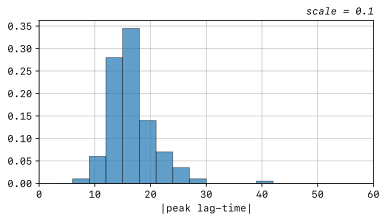

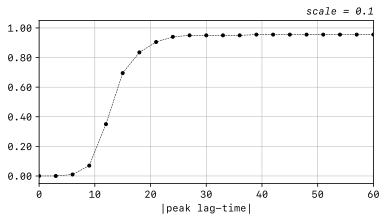

In [6]:
#generate lag-time distribution

from matplotlib.gridspec import GridSpec
from matplotlib.ticker import FormatStrFormatter
import scipy.interpolate
%config InlineBackend.figure_format = 'svg'
   
binwidth = 3
bins = np.arange(0, max(peak_corr) + binwidth, binwidth)
    
fig = plt.figure(figsize=(6,3), dpi=100);
ax = plt.gca()
weights = np.ones_like(peak_corr)/float(len(peak_corr))
counts, xp, bars = plt.hist(np.abs(peak_corr),alpha=0.7, density=False, edgecolor='black', linewidth=0.5, bins = bins, weights=weights)
xa = (xp[1:] + xp[:-1]) / 2
plt.plot(xa,counts,'k',linewidth=0.0,linestyle='--',marker='')
ticks(ax,10); ax.grid(linewidth=0.5);  ax.set_axisbelow(True);
ax.set_title('scale = ' + str(scale),fontproperties=fontit,fontsize=10, loc='right');
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax.set_xlabel('|peak lag-time|',fontproperties=font,fontsize=10);
ax.set_xlim(0, lim_lag)
max_lag = int(ax.get_xlim()[-1])

fig = plt.figure(figsize=(6,3), dpi=100);
ax = plt.gca()
plt.plot(xp[:-1],np.cumsum(counts),'k',linewidth=0.5,linestyle='--',marker='.')
ticks(ax,10); ax.grid(linewidth=0.5);  ax.set_axisbelow(True);
ax.set_title('scale = ' + str(scale),fontproperties=fontit,fontsize=10, loc='right');
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax.set_xlabel('|peak lag-time|',fontproperties=font,fontsize=10);
ax.set_xlim(0, lim_lag)

#generate interpolation for weighted averaging
counts=list(counts)
counts.append(counts[-1])
print(len(xp),len(counts))
xa = range(0,max(xp) + 1,3)
print(len(xa),len(counts))
y_inter  = scipy.interpolate.interp1d(xa, np.cumsum(counts))
x_interp = range(0,window_lag + 1)
y_interp = y_inter(x_interp)

# Weighted average cross-correlation (WACC)

Considering the new WACC method, the Kalman gain is maximised when the weighted average of $\mathsf{N}$ leading atmospheric forecasts are selected for the analysis step in SCDA. This dependence of Kalman gain on leading forecasts is written as

$$\mathsf{K} \propto \langle\mathsf{T_O}(t)\,\overline{\mathsf{T_A}(t_1,t_2)}^\mathsf{W}\rangle$$

where, $t_1 < t_2 \leq t$ contains $\mathsf{N}$ leading atmospheric forecasts. In principle, in regions where the oceanic and atmopheric forecasts are strongly correlated, deviations from the forecasts, as obtained through observations, provide the highest signal-to-noise ratio (SNR) for the analysis step of the DA. This is the core ideology behind the [LACC](https://www.dropbox.com/s/0bmtizuck5yafto/Lu15a.pdf?dl=0) as well as WACC method. For simplicity, we'll term the factor $\langle\mathsf{T_O}(t)\,\overline{\mathsf{T_A}(t_1,t_2)}^\mathsf{W}\rangle$ as 'Kalman Gain'.

Note: The <font color='blue'>KalGain()</font> function sets the DA step size equal to the peak cross-correlation lag time.

In [ ]:
import warnings
import scipy.interpolate
warnings.filterwarnings("error")

#set DA variables for LACC simulation
rel_samp = 1       #DA steps as a factor of resolution (%int)
obs_var = 0.1      #error variance in atmospheric observations 

def myround(x, base):
    return base * round(x/base)

def assim_data(x, y, t, step):
    x_assim = []; y_assim = []; t_assim = []
    for num, time in enumerate(t):
        if time % step == 0.0 and num >= step:
            x_assim.append(x[num])
            y_assim.append(np.mean(y[num + 1 - step:num + 1]))
            t_assim.append(time)
        else:
            continue
    return x_assim, y_assim, t_assim


def KalGain(ocean, atmos, t, win, item):
    ocean_assim, atmos_assim, time_assim = assim_data(ocean, atmos, t, rel_samp)
    ind = 0; KalCov = []; oce = []; atm = []; tim = []; flag = 0; KalGain = []
    for num, time in enumerate(time_assim):
        if time % win == 0.0 and num >= win:
            oce.append(ocean_assim[num])
            #atm.append(np.mean(atmos_assim[num + 1 - win:num + 1]))
            atm_mean = []
            for j in range(1,win + 2):
                atm_mean.append(np.mean(atmos_assim[num + 1 - j:num + 1]))
            atm.append(sum([x*y for x,y in zip(y_interp,atm_mean)]))
            tim.append(time)
            try:
                covar_matrix = np.cov(np.array([oce,atm]))
                covar   = covar_matrix[0][1]
                var_oce = covar_matrix[0][0]
                var_atm = covar_matrix[1][1]
                flag = 'lowered'
            except RuntimeWarning:
                covar   = 0.0
                var_oce = 1.0
                var_atm = 1.0
                flag = 'raised'  
            
            KalCov.append(covar)
            #obs_err = np.random.normal(0.0,obs_var)
            KalGain.append(covar/(var_atm + ((obs_var**2)/win)))
        else:
            continue
    return KalGain, flag

KalCovMat = []; KalCovMax = []; KalCovMaxVal = []
for i in range(samples):
    To_t = To_l[i]   
    Ta_t = Ta_l[i] 
    window = int(np.floor(myround(peak_corr[i],resolution)/resolution))
    window = int(np.floor(myround(window,rel_samp)/rel_samp))
    KalCovVec, flag  = KalGain(To_t, Ta_t, t, window_lag, i)
    DA_stab_ign = int(np.floor(time_stable*len(KalCovVec)))
    KalCovVec[:DA_stab_ign] = []
    
    if flag == 'raised':
        print('Flag')
        #print('RunTimeWarning for sample: ' + str(item))
    KalCovMat.append(KalCovVec)
    KalCovMax.append(np.argmax((KalCovVec)))
    KalCovMaxVal.append(np.max((KalCovVec)))

KalCovMatRaw = KalCovMat
lengths = []; power2 = []
for row in KalCovMat:
    lengths.append(len(row))
    power2.append(np.sum(row)/len(row))
renorm = max(lengths)

In [ ]:
from matplotlib.gridspec import GridSpec
%config InlineBackend.figure_format = 'svg'
        
#plot kalman gain statistics vs DA steps
fig = plt.figure(figsize=(10,5), dpi=200);
gs = GridSpec(4,4)
ax_joint = fig.add_subplot(gs[1:4,0:3])
ax_marg_y = fig.add_subplot(gs[1:4,3])

ax_joint.step(np.arange(1, samples + 1), KalCovMax, 'b',linewidth=1.0)
ax_marg_y.hist(KalCovMax,orientation="horizontal",alpha=0.8, density=True, edgecolor='black', linewidth=0.5, bins = 20)
ticks(ax_joint,10); ticks(ax_marg_y,10); plt.setp(ax_marg_y.get_xticklabels(), visible=True)
ax_joint.grid(linewidth=0.5); ax_joint.set_axisbelow(True);
ax_joint.autoscale(enable=True, axis='x', tight=True)

# Turn off tick labels on marginals
plt.setp(ax_marg_y.get_yticklabels(), visible=False)
plt.grid(linewidth=0.5); ax_marg_y.set_axisbelow(True);

# Set labels on joint
ax_joint.set_xlabel('samples',fontproperties=font,fontsize=10)
ax_joint.set_ylabel('peak K-Gain at DA step',fontproperties=font,fontsize=10);
ax_joint.set_title('peak K-Gain at DA step',fontproperties=fontit,fontsize=12, loc='right');

In [ ]:
from matplotlib.gridspec import GridSpec
%config InlineBackend.figure_format = 'svg'
        
#plot lag-times vs peak K at DA steps
fig = plt.figure(figsize=(6,6), dpi=200);
gs = GridSpec(4,4)
ax_joint = fig.add_subplot(gs[1:4,0:3])
ax_marg_x = fig.add_subplot(gs[0,0:3])
ax_marg_y = fig.add_subplot(gs[1:4,3])

ax_joint.scatter(np.abs(peak_corr), KalCovMax, c = KalCovMaxVal, s = 20, edgecolor='black', linewidth=0.2);
ax_marg_x.hist(np.abs(peak_corr),orientation="vertical",alpha=0.8, density=True, edgecolor='black', linewidth=0.5, bins = int(20/(1*resolution)))
ax_marg_y.hist(KalCovMax,orientation="horizontal",alpha=0.8, density=True, edgecolor='black', linewidth=0.5, bins = 20)
ticks(ax_joint,10); ticks(ax_marg_y,10); ticks(ax_marg_x,10); 
ax_joint.grid(linewidth=0.5); ax_joint.set_axisbelow(True);
ax_joint.autoscale(enable=True, axis='x', tight=True)

# Turn off tick labels on marginals
plt.setp(ax_marg_y.get_yticklabels(), visible=False); plt.setp(ax_marg_y.get_xticklabels(), visible=False)
plt.setp(ax_marg_x.get_yticklabels(), visible=False); plt.setp(ax_marg_x.get_xticklabels(), visible=False)
ax_marg_y.grid(linewidth=0.5); ax_marg_y.set_axisbelow(True); 
ax_marg_x.grid(linewidth=0.5); ax_marg_x.set_axisbelow(True);

# Set labels on joint
ax_joint.set_xlabel('|peak lag-time|',fontproperties=font,fontsize=12)
ax_joint.set_ylabel('peak K-Gain at DA step',fontproperties=font,fontsize=12);

In [ ]:
from scipy import interpolate
from mpl_toolkits.axes_grid1 import make_axes_locatable
from pylab import *
from matplotlib.colors import LogNorm

def fill_nan(A):
    '''
    interpolate to fill nan values
    '''
    inds = np.arange(A.shape[0])
    good = np.where(np.isfinite(A))
    f = interpolate.interp1d(inds[good], A[good],bounds_error=False)
    B = np.where(np.isfinite(A),A,f(inds))
    return B

def stretch_to(l, n, insert):
    Out = [insert] * n
    m = len(l)
    if m == 1:
        m = 2
    for i, x in enumerate(l):
        Out[i * (n - 1) // (m - 1)] = x
    return Out

NaN = float('nan')

#stretched list
KalCovLong = []
for row in KalCovMatRaw:
    row_long = stretch_to(row, renorm, NaN)
    row_new = fill_nan(np.array(row_long))
    KalCovLong.append(row_new)

#make rows equal lengths for plotting
maxLen = max(map(len, KalCovMat))
for row in KalCovMat:
    if len(row) < maxLen:
        row.extend(NaN for _ in range(maxLen - len(row)))
    
#draw trajectories of Cross-Corr
fig, ax = plt.subplots(figsize=(10,10), dpi=200);
#PlotMat = np.array(KalCovMat).transpose()
PlotMat = np.array(KalCovMat)
im = ax.matshow(PlotMat,origin='lower');
ax.grid(which='minor')
ax.set_aspect(1.0)

#colorbar
divider = make_axes_locatable(ax)
cax = divider.append_axes("bottom", size="3%", pad = 0.1)
cb = plt.colorbar(im, cax=cax,label='Kalman Gain',orientation="horizontal");
axc = cb.ax
text = axc.xaxis.label
text.set_font_properties(proplr)
ticks(axc,10);

ax.set_xlabel('DA step',fontproperties=font,fontsize=12); 
ax.xaxis.set_label_position('top');
ax.set_ylabel('sample number',fontproperties=font,fontsize=12); 

ticks(ax,10);
ax.set_title('Kalman Gain trajectories',fontproperties=fontit,fontsize=12, y=1.1, loc='right');


We test the total power per run by integrating the Kalman Gain over time for each sample. 

In [ ]:
%config InlineBackend.figure_format = 'svg'

fig = plt.figure(figsize=(10,5), dpi=100);
gs = GridSpec(4,4)
ax_joint = fig.add_subplot(gs[1:4,0:3])
ax_marg_y = fig.add_subplot(gs[1:4,3])

ax_joint.step(np.arange(1, samples + 1),power2,'b',linewidth=1.0)
ax_marg_y.hist(power2,orientation="horizontal",alpha=0.8, density=True, edgecolor='black', linewidth=0.5, bins = 10)
ticks(ax_joint,10); ticks(ax_marg_y,10); plt.setp(ax_marg_y.get_xticklabels(), visible=False)
ax_joint.grid(linewidth=0.5); ax_joint.set_axisbelow(True);
ax_joint.autoscale(enable=True, axis='x', tight=True)

# Turn off tick labels on marginals
plt.setp(ax_marg_y.get_yticklabels(), visible=False)
plt.grid(linewidth=0.5); ax_marg_y.set_axisbelow(True);

# Set labels on joint
ax_joint.set_xlabel('samples',fontproperties=font,fontsize=10)
ax_joint.set_ylabel('Power',fontproperties=font,fontsize=10);
ax_joint.set_title('Energetics',fontproperties=fontit,fontsize=12, loc='right');